FFHS DAS Data Science  
Semesterarbeit FS20  
Iwan Imsand

# Datenaufbereitung ```tripdata```

# Einleitung

In diesem Notebook werden die beschafften Tripdaten aufbereitet.

# Imports und Einstellung 

In [1]:
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np
import multiprocessing as mp
from functools import partial
from calendar import monthrange

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
plt.rcParams["figure.figsize"] = (18,8)

In [4]:
pd.options.display.float_format = '{:.5f}'.format

# Globale Variablen

Festlegung des Pfades aus welchem die Tripdaten gelesen werden.

In [5]:
path = './../data/citibike/tripdata'

Die Spalten wie sie beim Einlesen benannt werden sollen.

In [6]:
header_names = [
    'Trip Duration', 'Start Time', 'Stop Time',
    'Start Station ID', 'Start Station Name', 'Start Station Latitude', 'Start Station Longitude',
    'End Station ID', 'End Station Name', 'End Station Latitude', 'End Station Longitude',
    'Bike ID',
    'User Type', 'Birth Year', 'Gender'
]

Definition der Datentypen der einzelnen Spalten.

In [7]:
dtypes = {
    'Trip Duration': 'Int64',
    'Start Station ID': 'Int64',
    'End Station ID': 'Int64',
    'Bike ID': 'Int64',
    'User Type': 'category',
    'Birth Year': 'Int64',
    'Gender': 'category'
}

# Hilfsmethoden

## Einlesen der Dateien

Hilfsmethoden die zum einlesen der Dateien verwendet werden.

In [8]:
def get_files_iterator(path, filename_filter):
    """
    A file iterator for iterating over all files in a given path.
    A file filter can be used to include or exclude files from the iterator.
    """
    files = os.listdir(path)
    for file in files:
        if filename_filter(file):
            yield os.path.join(path, file)

In [9]:
def read(file):
    """
    Reads a file to a DataFrame with the read_csv method.
    """
    df = pd.read_csv(
        file, 
        header= 0, names=header_names,
        parse_dates=False,
        index_col=None,
        dtype=dtypes,
        na_values=['\\N']
    )
    
    return df

## Datum, Zeit und Zeitzone

In den Dateien sind sehr unterschiedliche Datums- und Zeitformate vorhanden. Daher werden hier Funktionen zur Verfügung gestellt, welche die nötigen Merkmale, entsprechend dem in der Datei verwendeten Format, in ein ```datetime``` konvertieren.

### Alle möglichen Formate aus allen Dateien auflisten

In [10]:
files_iterator = get_files_iterator(os.path.join(path, 'src'), lambda filename: re.match('[0-9]{4}.*\.csv', filename))

In [11]:
def get_datetime_examples(file):
    try:
        print('Get datetime examples from {}.'.format(file))
        df = read(file)
        
        return pd.DataFrame(
            [
                [
                    df['Start Time'].iloc[5],
                    df['Start Time'].iloc[-1],
                    df['Stop Time'].iloc[5],
                    df['Stop Time'].iloc[-1]
                ]
            ],
            index=[file],
            columns=['Start Time fifth', 'Start Time last', 'Stop Time fifth', 'Stop Time last']
        )
    
    except Exception as e:
        print('ERROR: Exception when getting datetime examples for file {}: {}'.format(file, str(e)))

In [12]:
try:
    # see https://www.machinelearningplus.com/python/parallel-processing-python/
    pool = mp.Pool(mp.cpu_count())
    df_datetime_examples_list = pool.map(func=get_datetime_examples, iterable=files_iterator)
finally:
    pool.close()
    
print("*** Completed! ***")

Get datetime examples from ./../data/citibike/tripdata/src/201706-citibike-tripdata.csv.Get datetime examples from ./../data/citibike/tripdata/src/201912-citibike-tripdata.csv.Get datetime examples from ./../data/citibike/tripdata/src/201510-citibike-tripdata.csv.Get datetime examples from ./../data/citibike/tripdata/src/201810-citibike-tripdata.csv.Get datetime examples from ./../data/citibike/tripdata/src/201311-citibike-tripdata.csv.Get datetime examples from ./../data/citibike/tripdata/src/201405-citibike-tripdata.csv.Get datetime examples from ./../data/citibike/tripdata/src/201905-citibike-tripdata.csv.Get datetime examples from ./../data/citibike/tripdata/src/201902-citibike-tripdata.csv.Get datetime examples from ./../data/citibike/tripdata/src/201412-citibike-tripdata.csv.Get datetime examples from ./../data/citibike/tripdata/src/201309-citibike-tripdata.csv.Get datetime examples from ./../data/citibike/tripdata/src/201605-citibike-tripdata.csv.Get datetime examples from ./../

In [13]:
df_datetime_examples = pd.concat(df_datetime_examples_list).sort_index()

Das DataFrame wird in eine Datei geschrieben, um die verschiedenen Formate zu untersuchen und eine entsprechend Funktion zur Ermittlung des Formats und der Konvertierung geschrieben.

In [14]:
df_datetime_examples.to_csv(os.path.join(path, 'datetime-examples-tripdata-citibike.csv'), index=True)

### Ermittlung des Datumsformats und korrektes Parsen

In [15]:
def parse_datetimes(file, df):
    """
    Convert fields to datetime with selecting the correct format for conversion.
    The timezone will be set to 'US/Eastern' directly after conversion.
    """
    yearmonth = int(file[-28:-22])
    datetime_format = ''
    
    if (yearmonth <= 201408 or 
        (yearmonth >= 201610 and yearmonth <= 201712)):
        datetime_format = '%Y-%m-%d %H:%M:%S'
    elif ((yearmonth >= 201409 and yearmonth <= 201412) or 
          (yearmonth >= 201504 and yearmonth <= 201505) or
          (yearmonth >= 201507 and yearmonth <= 201609)):
        datetime_format = '%m/%d/%Y %H:%M:%S'
    elif ((yearmonth >= 201501 and yearmonth <= 201503) or
         yearmonth == 201506):
        datetime_format = '%m/%d/%Y %H:%M'
    elif (yearmonth >= 201801):
        datetime_format = '%Y-%m-%d %H:%M:%S.%f'
    else:
        raise ValueError('Unknown YearMonth %s, can not evaluate correct datetime format of file %s!' % (yearmonth, file))
    
    df['Start Time'] = pd.to_datetime(df['Start Time'], format=datetime_format)
    df['Stop Time'] = pd.to_datetime(df['Stop Time'], format=datetime_format)
    
    # We need only seconds, microseconds can be removed
    df['Start Time'] = df['Start Time'].dt.floor('s')
    df['Stop Time'] = df['Stop Time'].dt.floor('s')
    
    return df

### Zeitzone 'US/Eastern' mit Berücksichtigung Daylight Saving Time (DST)

In [16]:
def dst_time(df):
    """
    Evaluates entries in daylight saving times for New York in timezone 'US/Eastern'
    """
        
    return (
        ((df >= '2010-03-14 02:00:00') & (df < '2010-11-07 02:00:00')) |
        ((df >= '2011-03-13 02:00:00') & (df < '2011-11-06 02:00:00')) |
        ((df >= '2012-03-11 02:00:00') & (df < '2012-11-04 02:00:00')) |
        ((df >= '2013-03-10 02:00:00') & (df < '2013-11-03 02:00:00')) |
        ((df >= '2014-03-09 02:00:00') & (df < '2014-11-02 02:00:00')) |
        ((df >= '2015-03-08 02:00:00') & (df < '2015-11-01 02:00:00')) |
        ((df >= '2016-03-13 02:00:00') & (df < '2016-11-06 02:00:00')) |
        ((df >= '2017-03-12 02:00:00') & (df < '2017-11-05 02:00:00')) |
        ((df >= '2018-03-11 02:00:00') & (df < '2018-11-04 02:00:00')) |
        ((df >= '2019-03-10 02:00:00') & (df < '2019-11-03 02:00:00')) |
        ((df >= '2020-03-08 02:00:00') & (df < '2020-11-01 02:00:00'))
    )

In [17]:
def update_tzinfo(df):
    """
    Updates the given DataFrame to 'US/Eastern' timezone with respecting DST.
    """
        
    dst_start = dst_time(df['Start Time'])
    df['Start Time'] = df['Start Time'].dt.tz_localize('US/Eastern', ambiguous=dst_start, nonexistent='NaT')
    
    dst_stop = dst_time(df['Stop Time'])
    df['Stop Time'] = df['Stop Time'].dt.tz_localize('US/Eastern', ambiguous=dst_stop, nonexistent='NaT')

    return df

<a id='hilfsmethoden_cleanup_missing_id'></a>
## Bereinigung fehlender Daten

Wegen viel fehlender Informationen in den Daten vom Monat Juni 2013, soll diese Datei nicht verarbeitet werden. Dazu den folgenden Dateifilter benutzen:

In [18]:
def no_missing_data_file_filter(filename):
    """
    Special file filter. Exclude files because of too much missing data.
    """
    return filename.endswith('citibike-tripdata.csv') & (filename.startswith('201306') == False)

Bereinigung fehlender Informationen im DataFrame. Dazu die folgende Funktion benutzen und diese direkt nach dem Einlesen einer Datei aufrufen:

In [19]:
def fix_missing_data(df):
    """
    Fix missing data in a given DataFrame.
    """
    
    # Set all NA in User Type to Customer
    df['User Type'] = df['User Type'].fillna(value='Customer')
    # Remove all rows with missing Station ID
    df = df.dropna(subset=['Start Station ID', 'End Station ID'])
    
    return df

Die folgende Funktion gibt eine kurze Statistik über die fehlenden Werte aus. Es wird die gesamte Anzahl fehlender Werte pro Spalte berechnet sowie der Prozentanteil gemessen an der Anzahl aller vorhandenen Einträgen.

In [20]:
def missing_values(df):
    """
    Create a DataFrame with statistics about the missing Data in the given DataFrame.
    """
    
    values = {
        'Count': df.isna().sum().values,
        'Percent': df.isna().sum().values / len(df) * 100,
    }
    return pd.DataFrame(data=values, index=df.columns.values)

## Bereinigung unrealistischer Daten für die tägliche Zusammenfassung

Für die tägliche Zusammenfassung sollten extreme Ausreisser sowie unrealistische Daten entfernt werden. Ansonsten könnte z.B. der Durchschnitt stark verfälscht werden. Die folgende Methode kann dafür benutzt werden um einen Datensatz vor der Aggregation zu bereinigen.

In [21]:
def clean_up_for_summary(df):  
    # remove unrealistic trips, would misleading the daily summaries
    df = (
        df[(df['Trip Duration'] <= 1*60*60*6) # only trips under 6h
           & (df['Linear Distance'] <= 30) # only trips with linear distance smaller than 30km between stations
           & (df['Age 2020'] <= 81) # only ages under 81 years (found out in question 'Who is the oldest user?')
          ]
    )
    
    return df

## Haversine zur Berechnung der Distanz zwischen zwei Punkten in km

Berechnet die Distanz in Kilometer zwischen zwei Punkten.

In [22]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """    
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

## Zusätzliche Merkmale

In [23]:
def add_linear_distance(df):
    """
    Add the linear distance column to the given DataFrame.
    """
    
    df['Linear Distance'] = haversine(
        df['Start Station Longitude'], df['Start Station Latitude'],
        df['End Station Longitude'], df['End Station Latitude']
    )
    return df

In [24]:
def add_age_2020(df):
    """
    Add the calculated age 2020 column to the given DataFrame.
    """
    
    df['Age 2020'] = 2020 - df['Birth Year']
    
    return df

# Datenaufbereitung, kompletter Oktober 2019

In [25]:
actual_filename = os.path.join(path, 'src', '201910-citibike-tripdata.csv')

In [26]:
tripdata = read(actual_filename)

In [27]:
tripdata = parse_datetimes(actual_filename, tripdata)

In [28]:
tripdata = update_tzinfo(tripdata)

In [29]:
tripdata = add_linear_distance(tripdata)

In [30]:
tripdata = add_age_2020(tripdata)

In [31]:
tripdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2092573 entries, 0 to 2092572
Data columns (total 17 columns):
 #   Column                   Dtype                     
---  ------                   -----                     
 0   Trip Duration            Int64                     
 1   Start Time               datetime64[ns, US/Eastern]
 2   Stop Time                datetime64[ns, US/Eastern]
 3   Start Station ID         Int64                     
 4   Start Station Name       object                    
 5   Start Station Latitude   float64                   
 6   Start Station Longitude  float64                   
 7   End Station ID           Int64                     
 8   End Station Name         object                    
 9   End Station Latitude     float64                   
 10  End Station Longitude    float64                   
 11  Bike ID                  Int64                     
 12  User Type                category                  
 13  Birth Year               In

In [32]:
tripdata.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Linear Distance,Age 2020
0,527,2019-10-01 00:00:05-04:00,2019-10-01 00:08:52-04:00,3746,6 Ave & Broome St,40.72431,-74.00473,223,W 13 St & 7 Ave,40.73782,-73.99995,41750,Subscriber,1993,1,1.55503,27
1,174,2019-10-01 00:00:15-04:00,2019-10-01 00:03:10-04:00,3301,Columbus Ave & W 95 St,40.79196,-73.96809,3283,W 89 St & Columbus Ave,40.78822,-73.97042,18264,Subscriber,1992,1,0.45920,28
2,759,2019-10-01 00:00:19-04:00,2019-10-01 00:12:59-04:00,161,LaGuardia Pl & W 3 St,40.72917,-73.99810,174,E 25 St & 1 Ave,40.73818,-73.97739,25525,Subscriber,1995,1,2.01235,25
3,615,2019-10-01 00:00:21-04:00,2019-10-01 00:10:36-04:00,254,W 11 St & 6 Ave,40.73532,-73.99800,477,W 41 St & 8 Ave,40.75641,-73.99003,30186,Subscriber,1992,1,2.43857,28
4,761,2019-10-01 00:00:26-04:00,2019-10-01 00:13:08-04:00,161,LaGuardia Pl & W 3 St,40.72917,-73.99810,174,E 25 St & 1 Ave,40.73818,-73.97739,25597,Subscriber,1992,1,2.01235,28


In [33]:
tripdata.tail()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Linear Distance,Age 2020
2092568,729,2019-10-31 23:59:12-04:00,2019-11-01 00:11:21-04:00,237,E 11 St & 2 Ave,40.73047,-73.98672,311,Norfolk St & Broome St,40.71723,-73.98802,25725,Subscriber,1995,1,1.47690,25
2092569,645,2019-10-31 23:59:17-04:00,2019-11-01 00:10:02-04:00,3259,9 Ave & W 28 St,40.74937,-73.99923,461,E 20 St & 2 Ave,40.73588,-73.98205,39583,Customer,1969,0,2.08493,51
2092570,257,2019-10-31 23:59:22-04:00,2019-11-01 00:03:40-04:00,3798,W 40 St & 5 Ave,40.75227,-73.98208,505,6 Ave & W 33 St,40.74901,-73.98848,21240,Subscriber,1985,1,0.64977,35
2092571,466,2019-10-31 23:59:23-04:00,2019-11-01 00:07:09-04:00,328,Watts St & Greenwich St,40.72406,-74.00966,361,Allen St & Hester St,40.71606,-73.99191,34916,Subscriber,1989,0,1.74037,31
2092572,81,2019-10-31 23:59:51-04:00,2019-11-01 00:01:13-04:00,539,Metropolitan Ave & Bedford Ave,40.71535,-73.96024,3093,N 6 St & Bedford Ave,40.71745,-73.95851,25745,Subscriber,1990,1,0.27570,30


In [34]:
tripdata.shape

(2092573, 17)

In [35]:
missing_values(tripdata)

,Count,Percent
Trip Duration,0,0.00000
Start Time,0,0.00000
Stop Time,0,0.00000
Start Station ID,0,0.00000
Start Station Name,0,0.00000
Start Station Latitude,0,0.00000
Start Station Longitude,0,0.00000
End Station ID,0,0.00000
End Station Name,0,0.00000
End Station Latitude,0,0.00000


## Export der Daten

In [36]:
tripdata.to_parquet(os.path.join(path, '201910-citibike-tripdata.parquet'), index=None)

In [37]:
tripdata.to_csv(os.path.join(path, '201910-citibike-tripdata.csv'), index=None)

# Untersuchung fehlender Daten über alle Jahre

In [38]:
files_iterator = get_files_iterator(os.path.join(path, 'src'), lambda filename: filename.endswith('citibike-tripdata.csv'))

In [39]:
def get_missing_values_stats(file):
    try:
        print('Get missing value stats from {}.'.format(file))
        df = read(file)
        
        return (file, missing_values(df))
    
    except Exception as e:
        print('ERROR: Exception when getting missing value stats file {}: {}'.format(file, e))

In [40]:
func = partial(get_missing_values_stats)

try:
    # see https://www.machinelearningplus.com/python/parallel-processing-python/
    pool = mp.Pool(mp.cpu_count())
    missing_stats = pool.map(func=func, iterable=files_iterator)

finally:
    pool.close()

print("*** Completed! ***")

Get missing value stats from ./../data/citibike/tripdata/src/201706-citibike-tripdata.csv.Get missing value stats from ./../data/citibike/tripdata/src/201905-citibike-tripdata.csv.Get missing value stats from ./../data/citibike/tripdata/src/201311-citibike-tripdata.csv.Get missing value stats from ./../data/citibike/tripdata/src/201510-citibike-tripdata.csv.Get missing value stats from ./../data/citibike/tripdata/src/201912-citibike-tripdata.csv.Get missing value stats from ./../data/citibike/tripdata/src/201810-citibike-tripdata.csv.Get missing value stats from ./../data/citibike/tripdata/src/201412-citibike-tripdata.csv.Get missing value stats from ./../data/citibike/tripdata/src/201902-citibike-tripdata.csv.Get missing value stats from ./../data/citibike/tripdata/src/201605-citibike-tripdata.csv.Get missing value stats from ./../data/citibike/tripdata/src/201606-citibike-tripdata.csv.Get missing value stats from ./../data/citibike/tripdata/src/202004-citibike-tripdata.csv.Get missin

In [41]:
def get_df_stats(stats):
    count_list = []
    percent_list = []
    for file, df_stats in stats:
        files_year_month = '{}-{}'.format(file[-28:-24], file[-24:-22])
        count_list.append(pd.DataFrame(data=df_stats['Count'].values, columns=[files_year_month], index=df_stats.index).T)
        percent_list.append(pd.DataFrame(data=df_stats['Percent'].values, columns=[files_year_month], index=df_stats.index).T)
        
    count = pd.concat(count_list).sort_index()
    percent = pd.concat(percent_list).sort_index()
    
    return (count, percent)

In [42]:
df_count, df_percent = get_df_stats(missing_stats)

In [43]:
df_count.sum()

Trip Duration                    0
Start Time                       0
Stop Time                        0
Start Station ID              2677
Start Station Name            2677
Start Station Latitude           0
Start Station Longitude          0
End Station ID               20736
End Station Name             20736
End Station Latitude         18059
End Station Longitude        18059
Bike ID                          0
User Type                    51780
Birth Year                 6229475
Gender                           0
dtype: int64

In [44]:
df_count.to_csv(os.path.join(path, 'missing-count-citibike-tripdata.csv'), index=True)
df_count.to_parquet(os.path.join(path, 'missing-count-citibike-tripdata.parquet'), index=True)
df_percent.to_csv(os.path.join(path, 'missing-percent-citibike-tripdata.csv'), index=True)
df_percent.to_parquet(os.path.join(path, 'missing-percent-citibike-tripdata.csv'), index=True)

In [45]:
def plot_missing_values(na_count):
    fig = plt.figure(constrained_layout=True)
    gs = gridspec.GridSpec(2,2, figure=fig)

    fig.suptitle('Missing Values', fontsize=16)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title('Over all years')
    ax1.set_xlabel('Missing values')
    ax1.barh(y=na_count.columns, width=na_count.sum().values)

    # new df with removed birth year for further plots
    na_count_without_birth_year = na_count.drop('Birth Year', axis=1)

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title('Over all years (excluded "Birth Year")')
    ax2.set_xlabel('Missing values')
    ax2.barh(y=na_count_without_birth_year.columns, width=na_count_without_birth_year.sum().values)
    
    plt.show()    

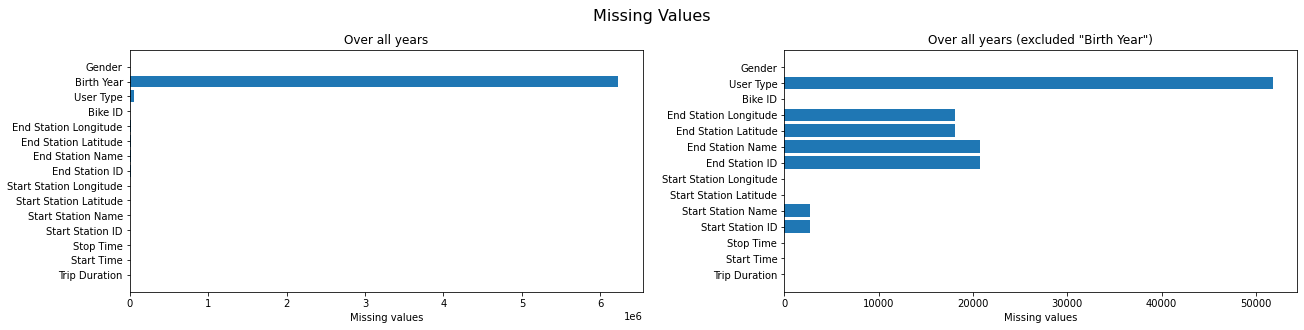

In [46]:
plot_missing_values(df_count)

Es ist ersichtlich das hier einige Daten fehlen. Bei Birth Year sind es so viele das alle anderen Spalten untergehen. Daher wurde rechts nochmal ein Plot erstellt ohne die Spalte Birth Year. So ist ersichtlich, dass auch bei User Type einige Daten fehlen, sowie Informationen zur End oder Start-Station nicht vorhanden sind.

## Untersuchung fehlender Daten auf Monatsebene

Damit man die Daten besser säubern kann, wird noch geprüft ob nur bei bestimmten Monaten oder Jahren Daten fehlen.

In [47]:
def plot_missing_values_months(na_count, na_percent):
    
    # only columns with na values, not interested in all others
    cols_with_na = df_count.loc[:, (df_count > 0).any()].columns
    
    for idx, col in enumerate(cols_with_na):
        print(col)

        fig = plt.figure(constrained_layout=True)
        gs = gridspec.GridSpec(2, 1, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])
        ax1.set_title(col)
        ax1.set_xlabel('Year and Month')
        ax1.set_ylabel('Count of Missing values')
        ax1.bar(x=na_count[col].index, height=na_count[col])
        ax1.tick_params(axis='x', rotation=90)

        ax2 = fig.add_subplot(gs[1, 0])
        ax2.set_title(col)
        ax2.set_xlabel('Year and Month')
        ax2.set_ylabel('Missing values in %')
        ax2.bar(x=na_percent[col].index, height=na_percent[col])
        ax2.tick_params(axis='x', rotation=90)
        
        plt.show()   

Start Station ID


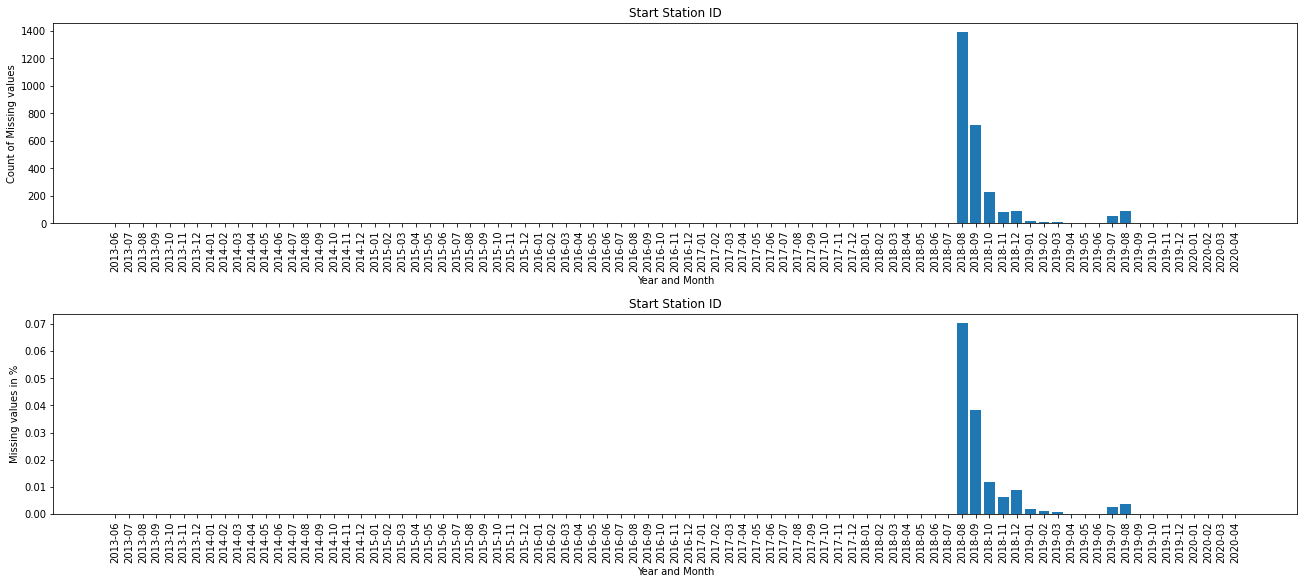

Start Station Name


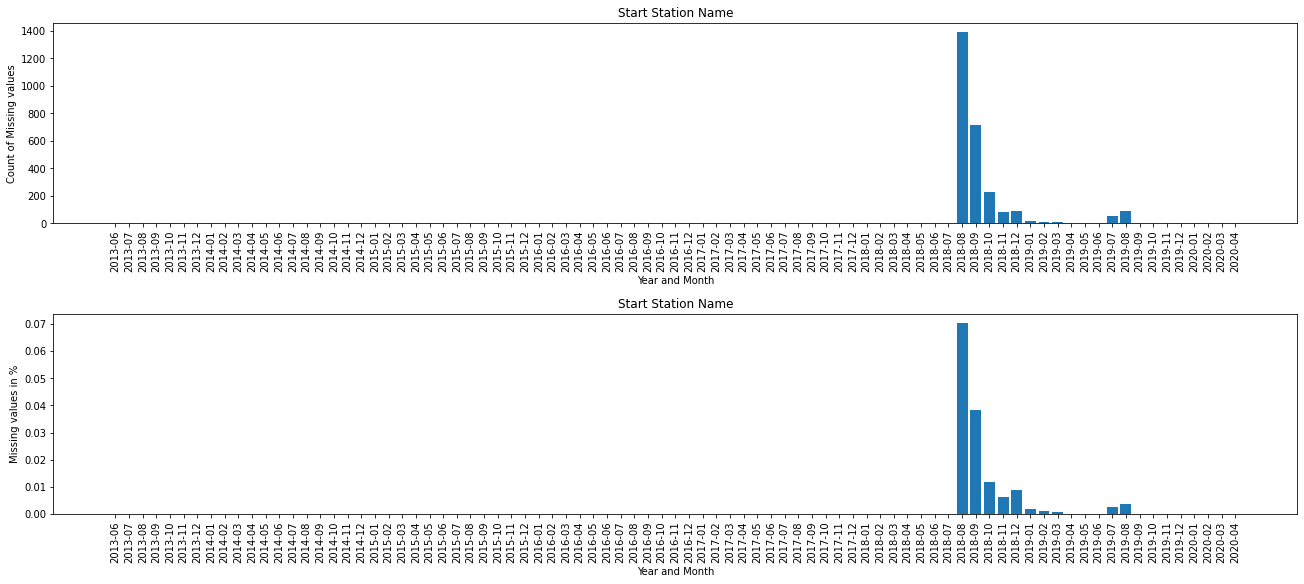

End Station ID


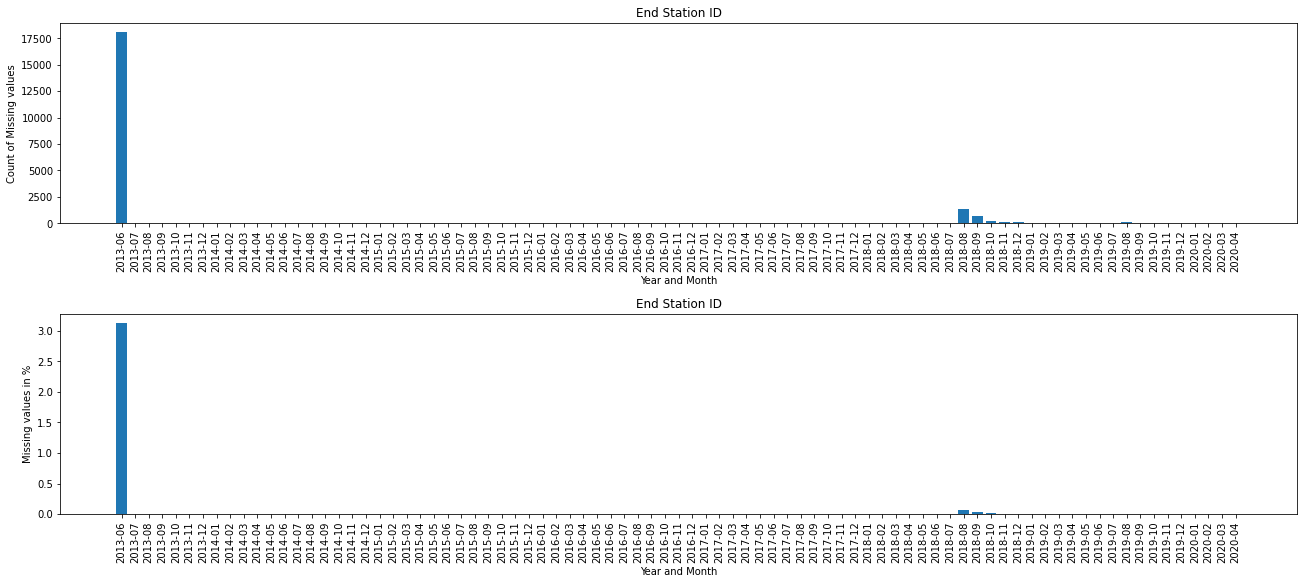

End Station Name


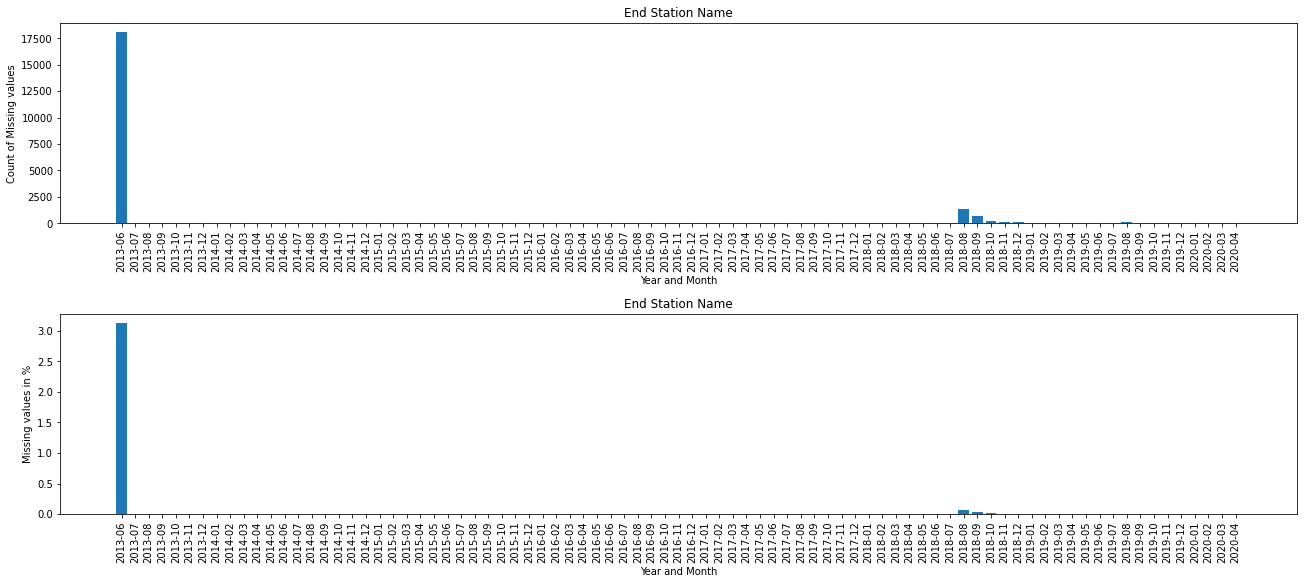

End Station Latitude


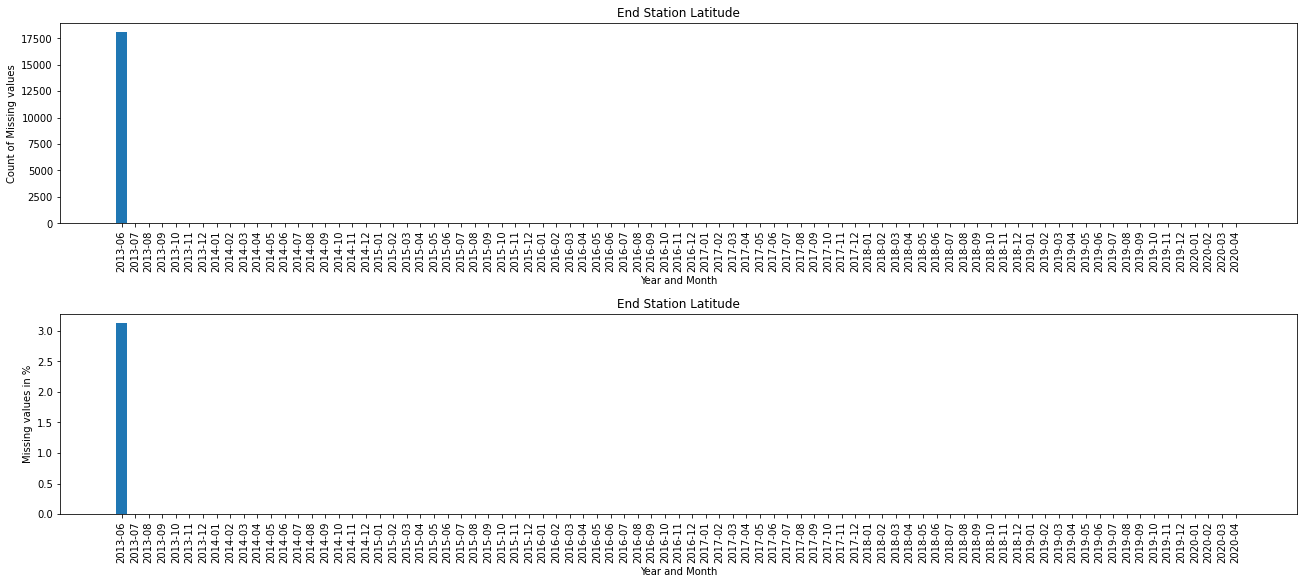

End Station Longitude


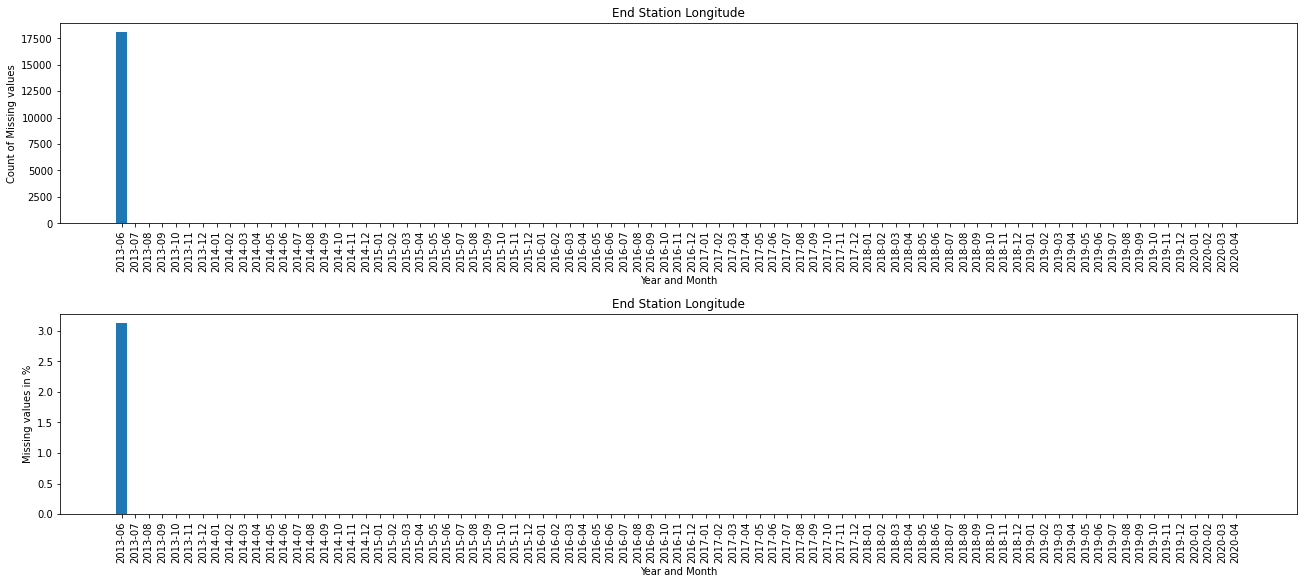

User Type


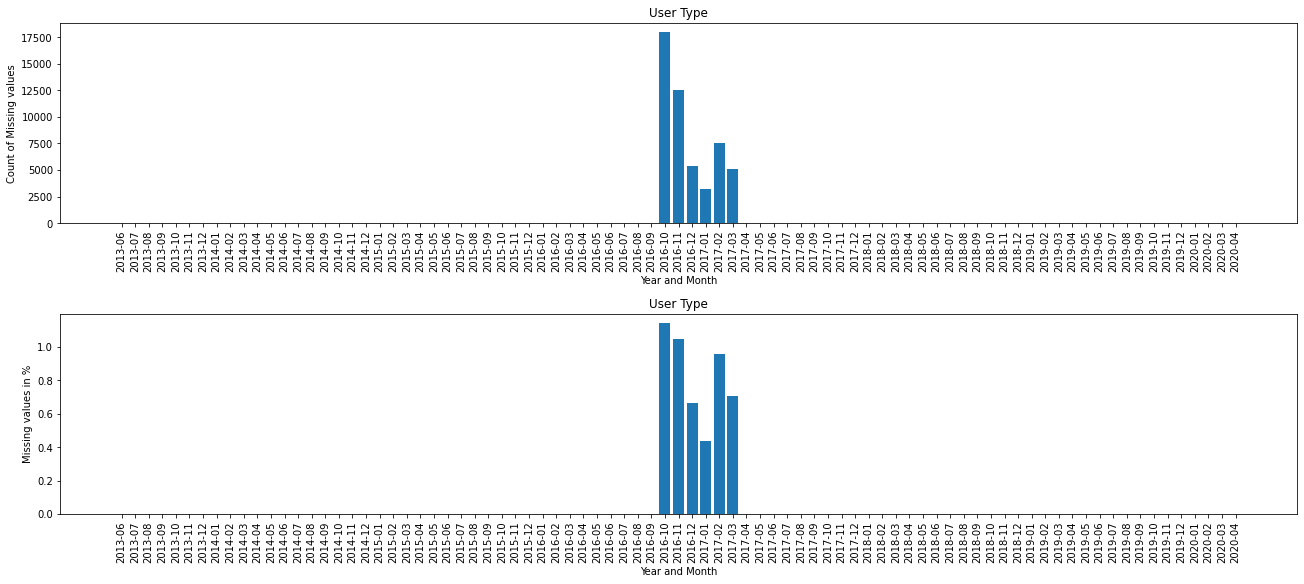

Birth Year


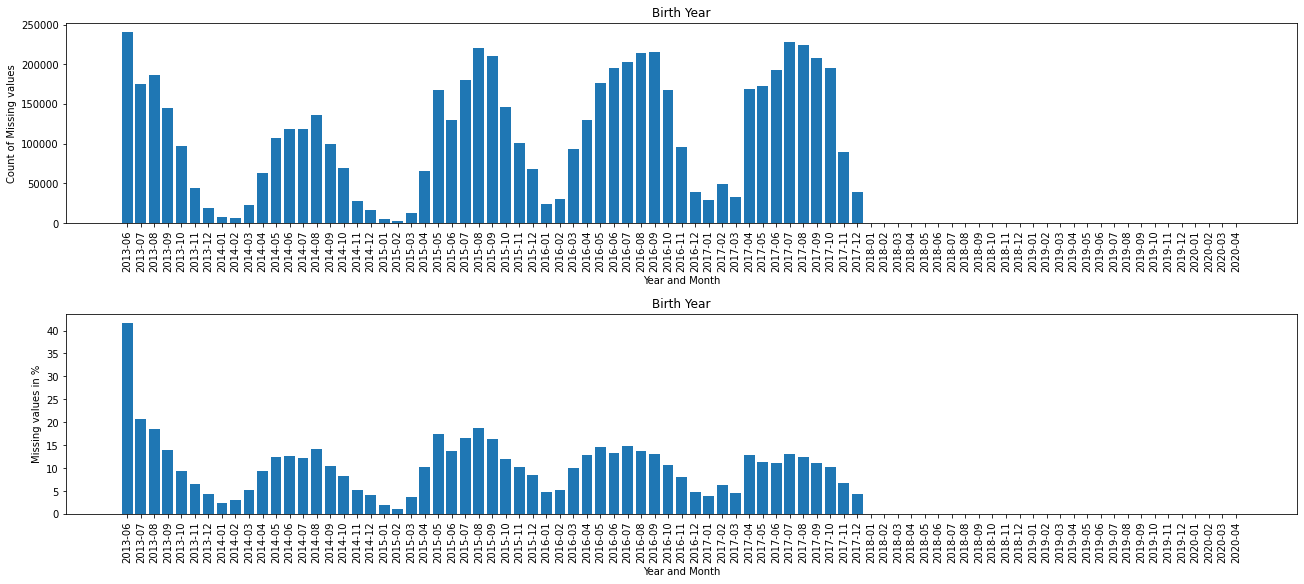

In [48]:
plot_missing_values_months(df_count, df_percent)

## Beurteilung und Bereinigungsfunktion für die nachfolgenden Datenaufbereitungen

Die Daten werden nun aufgrund der Plots gesäubert, d.h. es wird eine Methode zur Verfügung gestellt, welche in den folgenden Datenaufbereitungen benutzt werden kann.

**Aufgrund der Plots werden die Daten wie folgt beim Einlesen bereinigt:**

* Daten aus 06.2013 werden keine Berücksichtigt, d.h. die Datei wird gar nicht erst benutzt.
* Fehelende Daten in User Type werden mit Customer befüllt.
* Zeilen mit fehlender Station ID werden verworfen (der relative Anteil ist sehr klein, daher spielen diese keine Rolle).
* Am Geburtsjahr wird nichts verändert und einfach leer belassen falls dieses fehlt.

Die Funktionen dazu sind unter [Hilfsmethoden, Fehlende Daten bereinigen](#hilfsmethoden_cleanup_missing_id) definiert.

# Datenaufbereitung, zufällige Stichproben

**Damit bei jeder Generierung der Datei die gleichen Stichproben gezogen werden, muss immer ```SEED``` mitgegeben werden wenn ```sample()``` aufgerufen wird!**

## Für jeden Monat über alle Jahre

In [49]:
N_MONTH = 100 # Anzahl der Stichproben pro Monat
SEED_MONTH = 1234567890

In [50]:
files_iterator = get_files_iterator(os.path.join(path, 'src'), no_missing_data_file_filter)

In [51]:
def get_samples_per_month(number_of_samples, seed, file):
    try:
        print('Get samples from {}.'.format(file))
        df = read(file)
        df = fix_missing_data(df)
        df = parse_datetimes(file, df)
        df = update_tzinfo(df)
        
        df = add_linear_distance(df)
        df = add_age_2020(df)
        
        samples = df.sample(n=number_of_samples, random_state=seed)
        if len(samples) != number_of_samples:
            raise ValueError('Only {} samples exists, but should be {} (file: {})!'.format(len(samples), number_of_samples, file))
        return samples
    except Exception as e:
        print('ERROR: Exception when getting samples for file {}: {}'.format(file, str(e)))

In [52]:
func = partial(get_samples_per_month, N_MONTH, SEED_MONTH)

try:
    # see https://www.machinelearningplus.com/python/parallel-processing-python/
    pool = mp.Pool(mp.cpu_count())
    samples_per_month = pool.map(func=func, iterable=files_iterator)
finally:
    pool.close()
    
print("*** Completed! ***")

Get samples from ./../data/citibike/tripdata/src/201311-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201912-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201706-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201902-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201510-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201810-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201405-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201605-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201905-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201412-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201811-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201606-citibike-tripdata.csv.
Get samples from ./../data/citibike/tripdata/src/201307-citibik

In [53]:
tripdata_samples_per_month = pd.concat(samples_per_month)

In [54]:
tripdata_samples_per_month.shape

(8200, 17)

In [55]:
tripdata_samples_per_month = tripdata_samples_per_month.sort_values('Start Time')

In [56]:
tripdata_samples_per_month.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Linear Distance,Age 2020
10867,921,2013-07-01 18:35:06-04:00,2013-07-01 18:50:27-04:00,281,Grand Army Plaza & Central Park S,40.76440,-73.97371,249,Harrison St & Hudson St,40.71871,-74.00900,17128,Subscriber,1961,1,5.88607,59
16134,299,2013-07-01 22:48:13-04:00,2013-07-01 22:53:12-04:00,396,Lefferts Pl & Franklin Ave,40.68034,-73.95577,275,Washington Ave & Greene Ave,40.68650,-73.96563,15939,Subscriber,1984,1,1.07737,36
21829,333,2013-07-02 09:43:17-04:00,2013-07-02 09:48:50-04:00,546,E 30 St & Park Ave S,40.74445,-73.98304,536,1 Ave & E 30 St,40.74144,-73.97536,19973,Subscriber,1960,1,0.72780,60
32781,948,2013-07-02 18:09:36-04:00,2013-07-02 18:25:24-04:00,387,Centre St & Chambers St,40.71273,-74.00461,144,Nassau St & Navy St,40.69840,-73.98069,19363,Subscriber,1983,2,2.57005,37
38397,441,2013-07-02 21:51:10-04:00,2013-07-02 21:58:31-04:00,524,W 43 St & 6 Ave,40.75527,-73.98317,251,Mott St & Prince St,40.72318,-73.99480,18940,Customer,<NA>,0,3.70072,<NA>


In [57]:
missing_values(tripdata_samples_per_month)

,Count,Percent
Trip Duration,0,0.00000
Start Time,0,0.00000
Stop Time,0,0.00000
Start Station ID,0,0.00000
Start Station Name,0,0.00000
Start Station Latitude,0,0.00000
Start Station Longitude,0,0.00000
End Station ID,0,0.00000
End Station Name,0,0.00000
End Station Latitude,0,0.00000


In [58]:
tripdata_samples_per_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8200 entries, 10867 to 676916
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype                     
---  ------                   --------------  -----                     
 0   Trip Duration            8200 non-null   Int64                     
 1   Start Time               8200 non-null   datetime64[ns, US/Eastern]
 2   Stop Time                8200 non-null   datetime64[ns, US/Eastern]
 3   Start Station ID         8200 non-null   Int64                     
 4   Start Station Name       8200 non-null   object                    
 5   Start Station Latitude   8200 non-null   float64                   
 6   Start Station Longitude  8200 non-null   float64                   
 7   End Station ID           8200 non-null   Int64                     
 8   End Station Name         8200 non-null   object                    
 9   End Station Latitude     8200 non-null   float64                   
 10  End St

### Sortierung

In [59]:
tripdata_samples_per_month = tripdata_samples_per_month.sort_values('Start Time')

In [60]:
tripdata_samples_per_month.iloc[[1, -1]]

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Linear Distance,Age 2020
16134,299,2013-07-01 22:48:13-04:00,2013-07-01 22:53:12-04:00,396,Lefferts Pl & Franklin Ave,40.68034,-73.95577,275,Washington Ave & Greene Ave,40.68650,-73.96563,15939,Subscriber,1984,1,1.07737,36
676916,2929,2020-04-30 16:58:18-04:00,2020-04-30 17:47:08-04:00,533,Broadway & W 38 St,40.75300,-73.98722,533,Broadway & W 38 St,40.75300,-73.98722,43273,Subscriber,1962,1,0.00000,58


### Export der Daten

In [61]:
tripdata_samples_per_month.to_parquet(os.path.join(path, 'samples_per_month-citibike-tripdata.parquet'), index=None)

In [62]:
tripdata_samples_per_month.to_csv(os.path.join(path, 'samples_per_month-citibike-tripdata.csv'), index=None)

## Für jeden Tag über alle Jahre

In [63]:
N_DAY = 10 # Anzahl der Stichproben pro Monat
SEED_DAY = 1234567890

In [64]:
files_iterator = get_files_iterator(os.path.join(path, 'src'), no_missing_data_file_filter)

In [65]:
def get_samples_per_day(number_of_samples, seed, file):
    try:
        print('Get samples from {}.'.format(file))
        df = read(file)
        df = fix_missing_data(df)
        df = parse_datetimes(file, df)
        df = update_tzinfo(df)
        
        df = add_linear_distance(df)
        df = add_age_2020(df)
        
        df_grouped = df.groupby(df['Start Time'].dt.date)
                
        # Check number of days to be sure we have all data
        _, expected_num_days = monthrange(df['Start Time'].dt.year.unique()[0], df['Start Time'].dt.month.unique()[0])
        expected_samples = expected_num_days * number_of_samples
        
        samples = df_grouped.apply(lambda group_df: group_df.sample(number_of_samples, random_state=seed)).reset_index(drop=True)
        if len(samples) != expected_samples:
            print('WARN: Got {} samples, but should be {}. Month has {} days, file has {} days of data (file: {})!'.format(len(samples), expected_samples, expected_num_days, len(df_grouped), file))
        
        return samples
    except Exception as e:
        print('ERROR: Exception when getting samples for file {}: {}'.format(file, e))

In [66]:
func = partial(get_samples_per_day, N_DAY, SEED_DAY)

try:
    # see https://www.machinelearningplus.com/python/parallel-processing-python/
    pool = mp.Pool(mp.cpu_count())
    samples_per_day = pool.map(func=func, iterable=files_iterator)
finally:
    pool.close()
    
print("*** Completed! ***")

Get samples from ./../data/citibike/tripdata/src/201706-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201510-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201311-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201902-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201905-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201912-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201810-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201405-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201412-citibike-tripdata.csv.
Get samples from ./../data/citibike/tripdata/src/201605-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201309-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/202004-citibike-tripdata.csv.Get samples from ./../data/citibike/tripdata/src/201606-citibik

In [67]:
tripdata_samples_per_day = pd.concat(samples_per_day)

In [68]:
tripdata_samples_per_day.shape

(24880, 17)

In [69]:
missing_values(tripdata_samples_per_day)

,Count,Percent
Trip Duration,0,0.00000
Start Time,0,0.00000
Stop Time,0,0.00000
Start Station ID,0,0.00000
Start Station Name,0,0.00000
Start Station Latitude,0,0.00000
Start Station Longitude,0,0.00000
End Station ID,0,0.00000
End Station Name,0,0.00000
End Station Latitude,0,0.00000


In [70]:
tripdata_samples_per_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24880 entries, 0 to 309
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype                     
---  ------                   --------------  -----                     
 0   Trip Duration            24880 non-null  Int64                     
 1   Start Time               24880 non-null  datetime64[ns, US/Eastern]
 2   Stop Time                24880 non-null  datetime64[ns, US/Eastern]
 3   Start Station ID         24880 non-null  Int64                     
 4   Start Station Name       24880 non-null  object                    
 5   Start Station Latitude   24880 non-null  float64                   
 6   Start Station Longitude  24880 non-null  float64                   
 7   End Station ID           24880 non-null  Int64                     
 8   End Station Name         24880 non-null  object                    
 9   End Station Latitude     24880 non-null  float64                   
 10  End Station 

In [71]:
tripdata_samples_per_day.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Linear Distance,Age 2020
0,971,2017-06-01 23:35:37-04:00,2017-06-01 23:51:49-04:00,428,E 3 St & 1 Ave,40.72468,-73.98783,3428,8 Ave & W 16 St,40.74098,-74.00170,14766,Customer,1970,2,2.15703,50
1,2097,2017-06-01 16:07:59-04:00,2017-06-01 16:42:57-04:00,385,E 55 St & 2 Ave,40.75797,-73.96603,482,W 15 St & 7 Ave,40.73936,-73.99932,25237,Subscriber,1949,1,3.48532,71
2,1711,2017-06-01 17:41:35-04:00,2017-06-01 18:10:07-04:00,3221,47 Ave & 31 St,40.74300,-73.93561,366,Clinton Ave & Myrtle Ave,40.69326,-73.96890,25676,Subscriber,1980,1,6.20149,40
3,169,2017-06-01 11:55:45-04:00,2017-06-01 11:58:34-04:00,3117,Franklin St & Dupont St,40.73564,-73.95866,3112,Milton St & Franklin St,40.72906,-73.95779,21264,Subscriber,1989,2,0.73533,31
4,1776,2017-06-01 11:38:02-04:00,2017-06-01 12:07:39-04:00,3166,Riverside Dr & W 72 St,40.78058,-73.98562,491,E 24 St & Park Ave S,40.74096,-73.98602,29022,Subscriber,1990,2,4.40503,30


### Sortierung

In [72]:
tripdata_samples_per_day = tripdata_samples_per_day.sort_values('Start Time')

In [73]:
tripdata_samples_per_day.iloc[[1, -1]]

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Linear Distance,Age 2020
5,632,2013-07-01 08:07:51-04:00,2013-07-01 08:18:23-04:00,307,Canal St & Rutgers St,40.71427,-73.98990,305,E 58 St & 3 Ave,40.76096,-73.96724,19190,Subscriber,1987,2,5.53071,33
292,1044,2020-04-30 19:30:57-04:00,2020-04-30 19:48:22-04:00,3256,Pier 40 - Hudson River Park,40.72771,-74.01130,458,11 Ave & W 27 St,40.75140,-74.00523,27633,Subscriber,1983,2,2.68250,37


### Export der Daten

In [74]:
tripdata_samples_per_day.to_parquet(os.path.join(path, 'samples_per_day-citibike-tripdata.parquet'), index=None)

In [75]:
tripdata_samples_per_day.to_csv(os.path.join(path, 'samples_per_day-citibike-tripdata.csv'), index=None)

# Jahresmitglieder

## Tägliche Zusammenfassung über alle Jahre

Hier wird ein Export über alle Jahre erstellt. Dieser sieht wie folgt aus:

* Enthält nur ```User Type == 'Subscriber'```
* Enthält nur die Spalten ```Trip Duration```, ```Age 2020``` und ```Linear Distance```
* Aggregierte Werte ```mean, std, min, median``` und ```max```


In [76]:
files_iterator = get_files_iterator(os.path.join(path, 'src'), no_missing_data_file_filter)

In [77]:
def get_summary_per_day(file):
    try:
        print('Get summary from {}.'.format(file))
        df = read(file)
        
        df = df[df['User Type'] == 'Subscriber']
        
        df = fix_missing_data(df)
        df = parse_datetimes(file, df)
        df = update_tzinfo(df)
        
        df = add_linear_distance(df)
        df = add_age_2020(df)
        
        df = clean_up_for_summary(df)
        
        df_idx = df.set_index(pd.DatetimeIndex(data=df['Start Time'].dt.date, name='Date'))
        
        df_summary = (
            df_idx.groupby(by=['Date'])
            [['Trip Duration', 'Linear Distance', 'Age 2020']]
            .describe()
        )
        
        # flatten and rename columns
        df_summary.columns = df_summary.columns.to_flat_index().map(lambda tup: ' '.join(tup))
        
        # rename columns
        df_summary = df_summary.rename({
            'Trip Duration count': 'Trip count',
            'Trip Duration 50%': 'Trip Duration median',
            'Age 2020 50%': 'Age 2020 median',
            'Linear Distance 50%': 'Linear Distance median'
        }, axis=1)
        
        # drop not needed columns
        df_summary = df_summary.drop(columns=[
            'Trip Duration 25%', 'Trip Duration 75%',
            'Age 2020 25%', 'Age 2020 75%',
            'Linear Distance count', 'Linear Distance 25%', 'Linear Distance 75%'
        ])
        
        # replace all NaN values with positive infinity
        df_summary = df_summary.fillna(np.inf)
        
        return df_summary
    
    except Exception as e:
        print('ERROR: Exception when getting summary for file {}: {}'.format(file, e))

In [78]:
%%time
func = partial(get_summary_per_day)

try:
    # see https://www.machinelearningplus.com/python/parallel-processing-python/
    pool = mp.Pool(mp.cpu_count())
    summaries_per_day = pool.map(func=func, iterable=files_iterator)
finally:
    pool.close()
    
print("*** Completed! ***")

Get summary from ./../data/citibike/tripdata/src/201706-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201510-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201311-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201405-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201912-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201810-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201905-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201412-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201902-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201605-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/202004-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201606-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201309-citibike

In [79]:
summary = pd.concat(summaries_per_day)

In [80]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2488 entries, 2017-06-01 to 2019-08-31
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Trip count              2488 non-null   float64
 1   Trip Duration mean      2488 non-null   float64
 2   Trip Duration std       2488 non-null   float64
 3   Trip Duration min       2488 non-null   float64
 4   Trip Duration median    2488 non-null   float64
 5   Trip Duration max       2488 non-null   float64
 6   Linear Distance mean    2488 non-null   float64
 7   Linear Distance std     2488 non-null   float64
 8   Linear Distance min     2488 non-null   float64
 9   Linear Distance median  2488 non-null   float64
 10  Linear Distance max     2488 non-null   float64
 11  Age 2020 count          2488 non-null   float64
 12  Age 2020 mean           2488 non-null   float64
 13  Age 2020 std            2488 non-null   float64
 14  Age 2020 min          

In [81]:
summary.head()

,Trip count,Trip Duration mean,Trip Duration std,Trip Duration min,Trip Duration median,Trip Duration max,Linear Distance mean,Linear Distance std,Linear Distance min,Linear Distance median,Linear Distance max,Age 2020 count,Age 2020 mean,Age 2020 std,Age 2020 min,Age 2020 median,Age 2020 max
Date,,,,,,,,,,,,,,,,,
2017-06-01,60293.00000,791.96826,681.73947,61.00000,618.00000,21157.00000,1.93340,1.49338,0.00000,1.49237,12.16096,60293.00000,41.76584,11.51648,19.00000,39.00000,81.00000
2017-06-02,58542.00000,793.63107,688.89313,61.00000,617.00000,21474.00000,1.91491,1.48385,0.00000,1.47918,12.29248,58542.00000,41.61809,11.46294,19.00000,39.00000,81.00000
2017-06-03,41904.00000,866.65989,806.69600,61.00000,653.00000,21012.00000,1.85611,1.44386,0.00000,1.44084,11.62966,41904.00000,40.13393,11.42219,19.00000,37.00000,81.00000
2017-06-04,31726.00000,750.43888,684.47891,61.00000,559.00000,20446.00000,1.71003,1.36218,0.00000,1.32365,11.92261,31726.00000,40.15183,11.48919,19.00000,37.00000,81.00000
2017-06-05,50467.00000,741.58040,641.86686,61.00000,579.00000,20031.00000,1.86255,1.44175,0.00000,1.44045,12.36993,50467.00000,41.70351,11.56331,19.00000,39.00000,81.00000


In [82]:
assert (summary.isna().any(axis=1).sum() == 0), 'Missing values found!'

### Sortierung

In [83]:
summary = summary.sort_index()

In [84]:
summary.iloc[[1, -1]]

,Trip count,Trip Duration mean,Trip Duration std,Trip Duration min,Trip Duration median,Trip Duration max,Linear Distance mean,Linear Distance std,Linear Distance min,Linear Distance median,Linear Distance max,Age 2020 count,Age 2020 mean,Age 2020 std,Age 2020 min,Age 2020 median,Age 2020 max
Date,,,,,,,,,,,,,,,,,
2013-07-02,18641.00000,809.20809,706.63899,60.00000,649.00000,19715.00000,2.03158,1.52694,0.00000,1.59272,10.38871,18641.00000,45.20562,10.65699,23.00000,43.00000,81.00000
2020-04-30,12297.00000,899.94633,879.19177,61.00000,640.00000,19953.00000,1.77484,1.67552,0.00000,1.27195,16.66022,12297.00000,40.64471,12.09568,17.00000,38.00000,81.00000


### Export der Daten

In [85]:
summary.to_parquet(os.path.join(path, 'summary-daily-subscribers_only-citibike-tripdata.parquet'), index=True)

In [86]:
summary.to_csv(os.path.join(path, 'summary-daily-subscribers_only-citibike-tripdata.csv'), index=True)

## Tägliche Zusammenfassung über alle Jahre und zusätzlich gruppiert nach Geschlecht

Hier wird ein Export über alle Jahre erstellt. Dieser sieht wie folgt aus:

* Enthält nur ```User Type == 'Subscriber'```
* Gruppiert nach ```Date``` (entnommen aus ```Start Time```) und ```Gender```
* Enthält nur die Spalten ```Trip Duration```, ```Linear Distance``` und ```Birth Year```
* Aggregation mit ```count, mean, std, min, median``` und ```max```

In [87]:
files_iterator = get_files_iterator(os.path.join(path, 'src'), no_missing_data_file_filter)

In [88]:
def get_summary_per_day_grouped(file):
    try:
        print('Get summary from {}.'.format(file))
        df = read(file)
        
        df = df[df['User Type'] == 'Subscriber']
        
        df = fix_missing_data(df)
        df = parse_datetimes(file, df)
        df = update_tzinfo(df)
        
        df = add_linear_distance(df)
        df = add_age_2020(df)
        
        df = clean_up_for_summary(df)
        
        df_idx = df.set_index(pd.DatetimeIndex(data=df['Start Time'].dt.date, name='Date'))
        df_summary_grouped = (df_idx.groupby(by=['Date', 'Gender'])
             [['Trip Duration', 'Linear Distance', 'Age 2020']]
                 .describe()
        )
        # flatten and rename columns
        df_summary_grouped.columns = df_summary_grouped.columns.to_flat_index().map(lambda tup: ' '.join(tup))
        
         # rename columns
        df_summary_grouped = df_summary_grouped.rename({
            'Trip Duration count': 'Trip count',
            'Trip Duration 50%': 'Trip Duration median',
            'Age 2020 50%': 'Age 2020 median',
            'Linear Distance 50%': 'Linear Distance median'
        }, axis=1)
        
        # drop not needed columns
        df_summary_grouped = df_summary_grouped.drop(columns=[
            'Trip Duration 25%', 'Trip Duration 75%',
            'Age 2020 25%', 'Age 2020 75%',
            'Linear Distance count', 'Linear Distance 25%', 'Linear Distance 75%'
        ])
        
        # replace all NaN values with 0.0
        df_summary_grouped = df_summary_grouped.fillna(0.0)
        
        return df_summary_grouped
    
    except Exception as e:
        print('ERROR: Exception when getting summary for file {}: {}'.format(file, e))

In [89]:
%%time
func = partial(get_summary_per_day_grouped)

try:
    # see https://www.machinelearningplus.com/python/parallel-processing-python/
    pool = mp.Pool(mp.cpu_count())
    summaries_per_day_grouped = pool.map(func=func, iterable=files_iterator)
finally:
    pool.close()
    
print("*** Completed! ***")

Get summary from ./../data/citibike/tripdata/src/201311-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201510-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201912-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201405-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201706-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201810-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201412-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201811-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201902-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201605-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/202004-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201905-citibike-tripdata.csv.Get summary from ./../data/citibike/tripdata/src/201309-citibike

In [90]:
summary_grouped = pd.concat(summaries_per_day_grouped)

In [91]:
summary_grouped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7277 entries, (Timestamp('2017-06-01 00:00:00'), '0') to (Timestamp('2019-08-31 00:00:00'), '2')
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Trip count              7277 non-null   float64
 1   Trip Duration mean      7277 non-null   float64
 2   Trip Duration std       7277 non-null   float64
 3   Trip Duration min       7277 non-null   float64
 4   Trip Duration median    7277 non-null   float64
 5   Trip Duration max       7277 non-null   float64
 6   Linear Distance mean    7277 non-null   float64
 7   Linear Distance std     7277 non-null   float64
 8   Linear Distance min     7277 non-null   float64
 9   Linear Distance median  7277 non-null   float64
 10  Linear Distance max     7277 non-null   float64
 11  Age 2020 count          7277 non-null   float64
 12  Age 2020 mean           7277 non-null   float64
 13  Age 2020 std        

In [92]:
summary_grouped.head()

Trip count  Trip Duration mean  Trip Duration std  \
Date       Gender                                                      
2017-06-01 0        203.00000          1496.37931         3160.99429   
           1      44963.00000           757.79385          628.79358   
           2      15127.00000           884.09414          724.73135   
2017-06-02 0        236.00000          1487.11864         3162.07872   
           1      43710.00000           761.57044          632.07655   

                   Trip Duration min  Trip Duration median  Trip Duration max  \
Date       Gender                                                               
2017-06-01 0                63.00000             648.00000        15734.00000   
           1                61.00000             591.00000        18784.00000   
           2                61.00000             705.00000        21157.00000   
2017-06-02 0                91.00000             679.50000        17056.00000   
           1                61.00000             592.00000        21474.00000   

                   Linear Distance mean  Linear Distance std  \
Date       Gender                                              
2017-06-01 0                    1.70919              1.42591   
           1                    1.90699              1.48688   
           2                    2.01491              1.51041   
2017-06-02 0                    1.81515              1.51650   
           1                    1.89930              1.48225   

                   Linear Distance min  Linear Distance median  \
Date       Gender                                                
2017-06-01 0                   0.00000                 1.33354   
           1                   0.00000                 1.46288   
           2                   0.00000                 1.58558   
2017-06-02 0                   0.00000                 1.39103   
           1                   0.00000                 1.46575   

                   Linear Distance max  Age 2020 count  Age 2020 mean  \
Date       Gender                                                       
2017-06-01 0                   6.92261       203.00000       40.57143   
           1                  12.16096     44963.00000       42.08525   
           2                  11.62966     15127.00000       40.83248   
2017-06-02 0                   6.67682       236.00000       41.46610   
           1                  12.29248     43710.00000       41.95587   

                   Age 2020 std  Age 2020 min  Age 2020 median  Age 2020 max  
Date       Gender                                                             
2017-06-01 0           11.17097      21.00000         39.00000      71.00000  
           1           11.50679      19.00000         40.00000      81.00000  
           2           11.49875      20.00000         38.00000      80.00000  
2017-06-02 0           10.29289      22.00000         40.00000      71.00000  
           1           11.45778      19.00000         40.00000      81.00000

In [93]:
assert (summary_grouped.isna().any(axis=1).sum() == 0), 'Missing values found!'

### Sortierung

In [94]:
summary_grouped = summary_grouped.sort_index()

In [95]:
summary_grouped.iloc[[1, -1]]

,,Trip count,Trip Duration mean,Trip Duration std,Trip Duration min,Trip Duration median,Trip Duration max,Linear Distance mean,Linear Distance std,Linear Distance min,Linear Distance median,Linear Distance max,Age 2020 count,Age 2020 mean,Age 2020 std,Age 2020 min,Age 2020 median,Age 2020 max
Date,Gender,,,,,,,,,,,,,,,,,
2013-07-01,2,2808.00000,907.32621,736.53408,62.00000,740.00000,17260.00000,2.04062,1.49039,0.00000,1.64602,8.91266,2808.00000,43.21261,10.56697,24.00000,40.00000,78.00000
2020-04-30,2,3221.00000,976.06644,846.63441,61.00000,739.00000,13597.00000,1.90184,1.69891,0.00000,1.40006,11.43502,3221.00000,39.40515,11.78659,17.00000,36.00000,77.00000


### Export der Daten

In [96]:
summary_grouped.to_parquet(os.path.join(path, 'summary-daily-subscribers_only-gender_grouped-citibike-tripdata.parquet'), index=True)

In [97]:
summary_grouped.to_csv(os.path.join(path, 'summary-daily-subscribers_only-gender_grouped-citibike-tripdata.csv'), index=True)